<a href="https://colab.research.google.com/github/Rohan6672/Alien-Invader/blob/master/Week_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/MyDrive
%mkdir LFW_Week5
%cd LFW_Week5/

Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘LFW_Week5’: File exists
/content/drive/MyDrive/LFW_Week5


In [2]:
import requests
import tarfile
import os
import numpy as np
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
from typing import List
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.data import Dataset
from tensorflow.data import AUTOTUNE
from tensorflow import TensorSpec
from tensorflow import dtypes


In [3]:
# define URLs and filenames
zip_data_url = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
zip_data_name = os.path.basename(zip_data_url)

training_pairs_url = "http://vis-www.cs.umass.edu/lfw/pairsDevTrain.txt"
training_pairs_name = os.path.basename(training_pairs_url)

testing_pairs_url = "http://vis-www.cs.umass.edu/lfw/pairsDevTest.txt"
testing_pairs_name = os.path.basename(testing_pairs_url)


In [4]:
%ls
%cd MyDrive/

 ckpts/  'Face 2.jpeg'        LFW_Week5/   pairsDevTest.txt    Unknown.jpeg
 data/    face_recognition/   models/      pairsDevTrain.txt
[Errno 2] No such file or directory: 'MyDrive/'
/content/drive/MyDrive/LFW_Week5


In [5]:
# Download the dataset
# Note: it could take more than 5 min to download. 
# DO NOT stop this process until everything is downloaded
data_dir_name = 'data'
zip_data_path = os.path.join(data_dir_name, zip_data_name)
if not os.path.isdir(data_dir_name):
    os.mkdir(data_dir_name)
    print("Downloading data ...")
    
    # Retrieve the data from the given URL
    r = requests.get(zip_data_url, stream = True)
    with open(zip_data_path, 'wb') as f:
        f.write(r.raw.read())
    print(f"Downloading {zip_data_path} finished")


In [6]:
lfw_data_path = os.path.join(data_dir_name, 'lfw')
if not os.path.isdir(lfw_data_path):
  os.mkdir(lfw_data_path)
if not len(os.listdir(lfw_data_path)) >= 5749:
  print("Extracting data...")
  tar = tarfile.open(zip_data_path, "r")
  tar.extractall(data_dir_name)
  tar.close
  print("Finished extracting")



In [7]:
if not os.path.isfile(training_pairs_name):
  r = requests.get(training_pairs_url)
  with open(training_pairs_name, "wb") as file:
    file.write(r.content)
  print(f"{training_pairs_name} downloaded")

if not os.path.isfile(testing_pairs_name):
  r = requests.get(testing_pairs_url)
  with open(testing_pairs_name, "wb") as file:
    file.write(r.content)
  print(f"{testing_pairs_name} downloaded")



In [8]:
class LfwDataGenerator():
  def __init__(self, pairs_file_name, batch_size=4, anchor_shape=(96,96), n_channels=3, 
img_aug=False, face_align=False, data_path=lfw_data_path):
        self.pairs_file_name = pairs_file_name
        self.batch_size = batch_size
        self.anchor_shape = anchor_shape
        self.n_channels = n_channels
        self.img_aug = img_aug
        self.face_align = face_align
        self.positive_pairs = []
        self.negative_pairs = []
        with open(pairs_file_name, 'rt') as f:
            for line in f:
                tokens = line.split()
                if len(tokens) == 3:
              	     self.positive_pairs.append([(tokens[0],tokens[1]),(tokens[0],tokens[2])])
                elif len(tokens) == 4:
                    self.negative_pairs.append([(tokens[0],tokens[1]),(tokens[2],tokens[3])])
        
        min_len = min(len(self.positive_pairs), len(self.negative_pairs))
        self.pos_indexes = np.arange(min_len)
        self.neg_indexes = np.arange(min_len)

  def __len__(self):
      return len(self.pos_indexes)

  # helper functions to load images
  def get_image_path(self, name, id):
      path_name = os.path.join(lfw_data_path, name)
      return os.path.join(path_name, name) + "_" + f"{id}".zfill(4) + ".jpg"

  def load_image(self, name, id):
      img = cv2.imread(self.get_image_path(name, id))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img.astype('float32')
      img = img / 255.0
      return img
  def __getitem__(self, index):
      pos_pair = self.positive_pairs[self.pos_indexes[index]]
      neg_pair = self.negative_pairs[self.neg_indexes[index]]
      
      pos_name, pos_id_1 = pos_pair[0]
      anchor_img = self.load_image(pos_name, pos_id_1)
      
      pos_name, pos_id_2 = pos_pair[1]
      pos_img = self.load_image(pos_name, pos_id_2)
      
      neg_name, neg_id = neg_pair[0]
      if pos_name == neg_name:
          neg_name, neg_id = neg_pair[1]
      neg_img = self.load_image(neg_name, neg_id)
          
      return anchor_img, pos_img, neg_img
  def generate(self):
      for index in self.pos_indexes:
          yield self[index]
  def get_generator(self):
      tfdatagen = Dataset.from_generator(
          # create a tf.Dataset generator using the generate method
          self.generate, 
          # define the outputs of the tf.Dataset generator
          output_signature=(
              # image shapes and datatypes
              TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                          dtypes.float32),
              TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                          dtypes.float32),
              TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                          dtypes.float32))
      )
          
      return (tfdatagen
          # set the batch size
          .batch(self.batch_size)
          # shuffle to randomly select images
          .shuffle(self.batch_size*2)
          # prefetch for performance optimization
          .prefetch(AUTOTUNE)
          )







In [9]:
def get_generator(self):
    tfdatagen = Dataset.from_generator(
        # create a tf.Dataset generator using the generate method
        self.generate, 
        # define the outputs of the tf.Dataset generator
        output_signature=(
            # image shapes and datatypes
            TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                        dtypes.float32),
            TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                        dtypes.float32),
            TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                        dtypes.float32))
    )
        
    return (tfdatagen
        # set the batch size
        .batch(self.batch_size)
        # shuffle to randomly select images
        .shuffle(self.batch_size*2)
        # prefetch for performance optimization
        .prefetch(AUTOTUNE)
        )



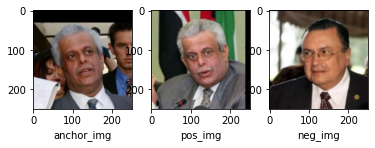

In [10]:
data_generator = LfwDataGenerator(pairs_file_name=training_pairs_name, img_aug=False, face_align=False)
anchor_img, pos_img, neg_img = data_generator[7]

plt.subplot(1, 3, 1)
plt.imshow(anchor_img)
plt.xlabel("anchor_img")

plt.subplot(1, 3, 2)
plt.imshow(pos_img)
plt.xlabel("pos_img")

plt.subplot(1, 3, 3)
plt.imshow(neg_img)
plt.xlabel("neg_img")

plt.show()





In [11]:
!git clone https://github.com/krasserm/face-recognition.git
!mv face-recognition face_recognition


Cloning into 'face-recognition'...
remote: Enumerating objects: 173, done.
remote: Total 173 (delta 0), reused 0 (delta 0), pack-reused 173
Receiving objects: 100% (173/173), 16.84 MiB | 14.72 MiB/s, done.
Resolving deltas: 100% (29/29), done.


In [12]:
# download the face landmarks model for face alignment
import bz2
from face_recognition.align import AlignDlib
from urllib.request import urlopen

def download_landmarks(landmarks_path):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    print("Starting download:", url)
    with urlopen(url) as src, open(landmarks_path, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)
    print("Downloaded to:", landmarks_path)

landmarks_dir = 'models'
landmarks_path = os.path.join(landmarks_dir, 'landmarks.dat')
if not os.path.exists(landmarks_path):
    os.makedirs(landmarks_dir)
    download_landmarks(landmarks_path)


In [13]:
    def __init__(self, pairs_file_name, batch_size=4, anchor_shape=(96,96), n_channels=3,
img_aug=False, face_align=False, landmarks_path=landmarks_path,
data_path=lfw_data_path):
        self.alignment = AlignDlib(landmarks_path) # create the face alignment model
        self.augmenter = iaa.Sequential([ # create the image augmenter
            iaa.Crop(px=(0,16)), # crop images from each side by 0 to 16px (randomly chosen)
            iaa.Fliplr(0.5), # horizontally flip 50% of the images
            iaa.GaussianBlur(sigma=(0,1.0)), # blur images with a sigma of 0 to 3.0
            iaa.GammaContrast((0.5, 2.0)), # adjust the image contrast 
        ])



In [14]:
def augment_image(self, img):
    return self.augmenter(images=[img])[0]


In [15]:
def align_image(self, img):
    img = (img*255).astype("uint8")
    alignment = self.alignment
    bb = alignment.getLargestFaceBoundingBox(img) # get face bounding box
    if bb is not None:
        img = alignment.align(self.anchor_shape[0],img,bb,
                                landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
    return img.astype("float32") / 255

In [16]:
def __getitem__(self, index):

  if self.face_align:
      anchor_img = self.align_image(anchor_img)
      pos_img = self.align_image(pos_img)
      neg_img = self.align_image(neg_img)

  if self.img_aug:
      anchor_img = self.augment_image(anchor_img)
      pos_img = self.augment_image(pos_img)
      neg_img = self.augment_image(neg_img)

  return anchor_img, pos_img, neg_img


In [17]:
data_generator_aug = LfwDataGenerator(pairs_file_name = training_pairs_name, 
img_aug = True, face_align=False)


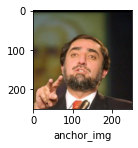

In [18]:
anchor_img, pos_img, neg_img = data_generator_aug[5]

plt.subplot(1, 3, 1)
plt.imshow(anchor_img)
plt.xlabel("anchor_img")


plt.show()


Text(0.5, 0, 'pos_img')

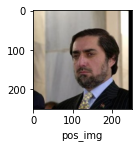

In [19]:
anchor_img, pos_img, neg_img = data_generator_aug[5]
plt.subplot(1, 3, 3)
plt.imshow(pos_img)
plt.xlabel("pos_img")

Text(0.5, 0, 'neg_img')

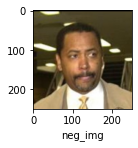

In [20]:
anchor_img, pos_img, neg_img = data_generator_aug[5]
plt.subplot(1, 3, 2)
plt.imshow(neg_img)
plt.xlabel("neg_img")


In [21]:
data_generator_aug_align = LfwDataGenerator(pairs_file_name = training_pairs_name, 
img_aug = True, face_align=True)



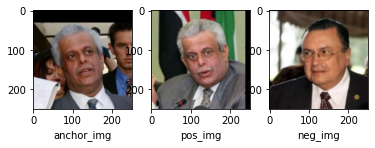

In [22]:
anchor_img, pos_img, neg_img = data_generator_aug_align[7]

plt.subplot(1, 3, 1)
plt.imshow(anchor_img)
plt.xlabel("anchor_img")

plt.subplot(1, 3, 2)
plt.imshow(pos_img)
plt.xlabel("pos_img")

plt.subplot(1, 3, 3)
plt.imshow(neg_img)
plt.xlabel("neg_img")

plt.show()


In [23]:
import random
fire_data_dir = '/content/drive/Shareddrives/2022 FIRE COML STUDENTS/Spring/Face Photos Dataset/'

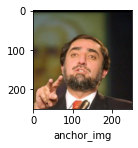

In [24]:
class COMLFaceGenerator():
    def __init__(self, face_data_dir, batch_size=4, anchor_shape=(96,96), n_channels=3, img_aug=False, face_align=False, landmarks_path=landmarks_path, data_path=lfw_data_path):
      
        self.face_data_dir = face_data_dir
        self.batch_size = batch_size
        self.anchor_shape = anchor_shape
        self.n_channels = n_channels
        self.img_aug = img_aug
        self.face_align = face_align

        # read the pairs_file_name and stores the image paths as lists of tuples of either positive or negative pairs
        self.positive_pairs = []
        self.negative_pairs = []
        print(face_data_dir)
        persons = os.listdir(face_data_dir)
        img_exts = ('.png','.jpg','.jpeg')
        for i, person in enumerate(persons):
          person_path = os.path.join(face_data_dir, person)
          person_files = os.listdir(person_path)
          image_files = [image_file for image_file in person_files if image_file.endswith(img_exts)]

          if len(image_files) >= 2:
            image_ids = np.arange(len(image_files))
            np.random.shuffle(image_ids)
            self.positive_pairs.append([(person, image_files[image_ids[0]]),(person,image_files[image_ids[1]])])
          
            remaining_persons = persons.copy()
            remaining_persons.pop(i)
        
            other_person = np.random.choice(remaining_persons)
            other_person_path = os.path.join(face_data_dir, other_person)
            other_person_files = os.listdir(other_person_path)
            other_person_image_files = [image_file for image_file in other_person_files if image_file.endswith(img_exts)]
            if len(other_person_image_files) >= 1:
              random_id = random.randrange(len(other_person_image_files))
              self.negative_pairs.append([(person,image_files[image_ids[0]]),(other_person,other_person_image_files[random_id])])
            min_len = min(len(self.positive_pairs), len(self.negative_pairs))
            self.pos_indexes = np.arange(min_len)
            self.neg_indexes = np.arange(min_len)
            self.alignment = AlignDlib(landmarks_path) # create the face alignment model
            self.augmenter = iaa.Sequential([ # create the image augmenter
                iaa.Crop(px=(0,16)), # crop images from each side by 0 to 16px (randomly chosen)
                iaa.Fliplr(0.5), # horizontally flip 50% of the images
                iaa.GaussianBlur(sigma=(0,1.0)), # blur images with a sigma of 0 to 3.0
                iaa.GammaContrast((0.5, 2.0)), # adjust the image contrast 
            ])
    def __getitem__(self, index):

      if self.face_align:
          anchor_img = self.align_image(anchor_img)
          pos_img = self.align_image(pos_img)
          neg_img = self.align_image(neg_img)

      if self.img_aug:
          anchor_img = self.augment_image(anchor_img)
          pos_img = self.augment_image(pos_img)
          neg_img = self.augment_image(neg_img)
      def __len__(self):
        return len(self.pos_indexes)

    # helper functions to load images
    def get_image_path(self, name, id):
        path_name = os.path.join(lfw_data_path, name)
        return os.path.join(path_name, name) + "_" + f"{id}".zfill(4) + ".jpg"

    def load_image(self, name, id):
        img = cv2.imread(self.get_image_path(name, id))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32')
        img = img / 255.0
        return img
    def __getitem__(self, index):
        pos_pair = self.positive_pairs[self.pos_indexes[index]]
        neg_pair = self.negative_pairs[self.neg_indexes[index]]
        
        pos_name, pos_id_1 = pos_pair[0]
        anchor_img = self.load_image(pos_name, pos_id_1)
        
        pos_name, pos_id_2 = pos_pair[1]
        pos_img = self.load_image(pos_name, pos_id_2)
        
        neg_name, neg_id = neg_pair[0]
        if pos_name == neg_name:
            neg_name, neg_id = neg_pair[1]
        neg_img = self.load_image(neg_name, neg_id)
            
        return anchor_img, pos_img, neg_img
    def generate(self):
        for index in self.pos_indexes:
            yield self[index]
    def get_generator(self):
      tfdatagen = Dataset.from_generator(
          # create a tf.Dataset generator using the generate method
          self.generate, 
          # define the outputs of the tf.Dataset generator
          output_signature=(
              # image shapes and datatypes
              TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                          dtypes.float32),
              TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                          dtypes.float32),
              TensorSpec((self.anchor_shape[0], self.anchor_shape[1], self.n_channels), 
                          dtypes.float32))
      )
          
      return (tfdatagen
          # set the batch size
          .batch(self.batch_size)
          # shuffle to randomly select images
          .shuffle(self.batch_size*2)
          # prefetch for performance optimization
          .prefetch(AUTOTUNE)
          )

      return anchor_img, pos_img, neg_img
    def get_image_path(self, name, id):
      path_name = os.path.join(self.face_data_dir, name, id)
      return path_name

# data_generator = COMLFaceGenerator(fire_data_dir, img_aug=False, face_align=False)
anchor_img, pos_img, neg_img = data_generator[5]




plt.subplot(1, 3, 3)
plt.imshow(anchor_img)
plt.xlabel("anchor_img")
plt.show()





Text(0.5, 0, 'pos_img')

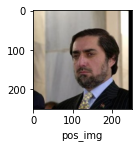

In [25]:
plt.subplot(1, 3, 2)
plt.imshow(pos_img)
plt.xlabel("pos_img")
# plt.show()

Text(0.5, 0, 'neg_img')

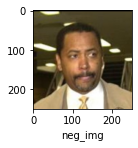

In [26]:
plt.subplot(1, 3, 1)
plt.imshow(neg_img)
plt.xlabel("neg_img")
# plt.show()